<a href="https://colab.research.google.com/github/Faraaztqureshi/DS-Unit-2-Linear-Models/blob/master/Faraaz_Qureshi_019_DS10_assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

# Data Exploration

In [0]:
## Get my libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [34]:
## inspect the df
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [35]:
df.shape

(421, 59)

In [0]:
## check for missing values
df.isnull().sum()

In [0]:
## get the percentage of missing data
percent_missing = df.isnull().sum() * 100 / len(df)

## store the missing data information
percent_missing


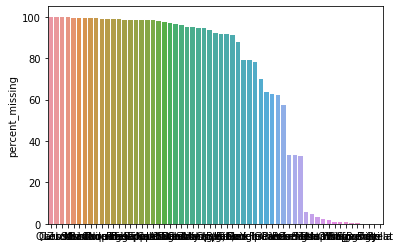

In [71]:
## visualize features with the most missing data

## make missing data into a df
percent_missing = pd.DataFrame(percent_missing)

## name the column
percent_missing.columns = ['percent_missing']

## sort values from highest percentage missing to lowest
percent_missing = percent_missing.sort_values('percent_missing', ascending=False)

## create a barplot to show how many features have many missing values
sns.barplot(x = percent_missing.index, y='percent_missing', data= percent_missing)
plt.show()

In [0]:
## there a lot of columns with a many missing values so I'm going to drop anything with more than 100 missing values
percent_missing

In [74]:
percent_missing.index

Index(['Queso', 'Carrots', 'Lobster', 'Zucchini', 'Sushi', 'Ham', 'Bacon',
       'Mushroom', 'Corn', 'Taquito', 'Nopales', 'Chile relleno', 'Egg',
       'Fish', 'Pineapple', 'Bell peper', 'Salsa.1', 'Tomato', 'NonSD',
       'Cabbage', 'Lettuce', 'Avocado', 'Cilantro', 'Onion', 'Chicken',
       'Shrimp', 'Density (g/mL)', 'Mass (g)', 'Chips', 'Unreliable', 'Beans',
       'Rice', 'Sauce', 'Pork', 'Google', 'Yelp', 'Sour cream', 'Fries',
       'Guac', 'Pico', 'Cheese', 'Beef', 'Volume', 'Circum', 'Length', 'Salsa',
       'Temp', 'Meat', 'Meat:filling', 'Cost', 'Wrap', 'Hunger', 'Fillings',
       'Uniformity', 'Synergy', 'Burrito', 'Date', 'Tortilla', 'Great'],
      dtype='object')

In [0]:
df.drop(labels = ['Queso', 'Carrots', 'Lobster', 'Zucchini', 'Sushi', 'Ham', 'Bacon',
       'Mushroom', 'Corn', 'Taquito', 'Nopales', 'Chile relleno', 'Egg',
       'Fish', 'Pineapple', 'Bell peper', 'Salsa.1', 'Tomato', 'NonSD',
       'Cabbage', 'Lettuce', 'Avocado', 'Cilantro', 'Onion', 'Chicken',
       'Shrimp', 'Density (g/mL)', 'Mass (g)', 'Chips', 'Unreliable', 'Beans',
       'Rice', 'Sauce', 'Pork', 'Google', 'Yelp', 'Sour cream', 'Fries',
       'Guac', 'Pico', 'Cheese', 'Beef'], axis = 1, inplace = True)

In [84]:
df.shape
df.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great
0,California,1/18/2016,6.49,3.0,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,False
1,California,1/24/2016,5.45,3.5,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,False
2,Carnitas,1/24/2016,4.85,1.5,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,False
3,Asada,1/24/2016,5.25,2.0,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,False
4,California,1/27/2016,6.59,4.0,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,True


In [0]:
a = df.corr()

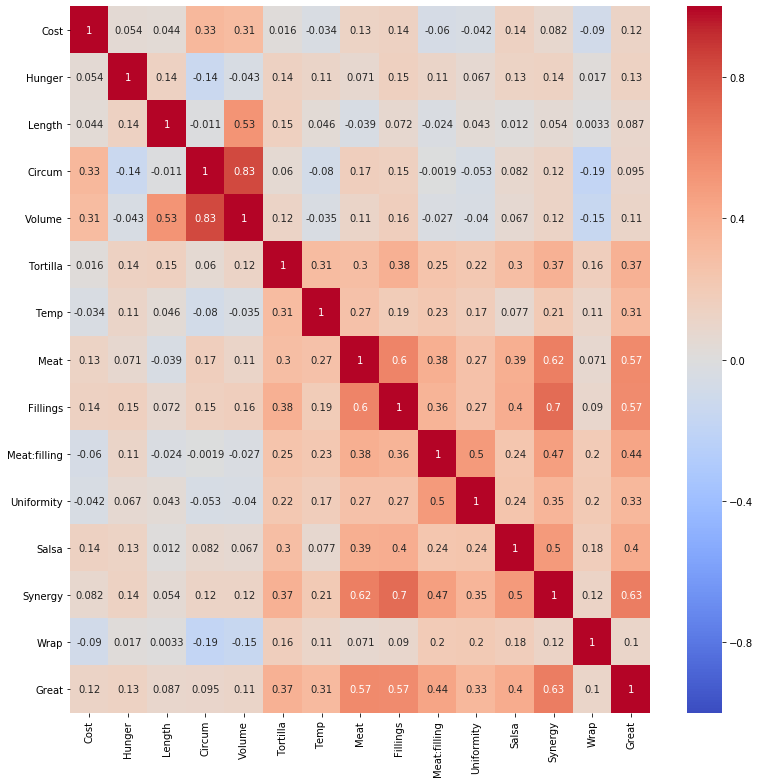

In [87]:
plt.figure(figsize=(13,13))
sns.heatmap(a, vmin=-1, cmap='coolwarm', annot=True)
plt.show()

In [89]:
df.dtypes

Burrito          object
Date             object
Cost            float64
Hunger          float64
Length          float64
Circum          float64
Volume          float64
Tortilla        float64
Temp            float64
Meat            float64
Fillings        float64
Meat:filling    float64
Uniformity      float64
Salsa           float64
Synergy         float64
Wrap            float64
Great              bool
dtype: object

In [90]:
## since sale date is an object lets make it a date time
df['Date'] = df['Date'].apply(pd.to_datetime)
df.dtypes

Burrito                 object
Date            datetime64[ns]
Cost                   float64
Hunger                 float64
Length                 float64
Circum                 float64
Volume                 float64
Tortilla               float64
Temp                   float64
Meat                   float64
Fillings               float64
Meat:filling           float64
Uniformity             float64
Salsa                  float64
Synergy                float64
Wrap                   float64
Great                     bool
dtype: object

In [103]:
df.isnull().sum()

Burrito           0
Date              0
Cost              7
Hunger            3
Length          138
Circum          140
Volume          140
Tortilla          0
Temp             20
Meat             14
Fillings          3
Meat:filling      9
Uniformity        2
Salsa            25
Synergy           2
Wrap              3
Great             0
year              0
dtype: int64

# Train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later

In [0]:
df['year'] = df['Date'].dt.year

In [94]:
df['year'].value_counts()

2016    296
2017     85
2018     27
2019     10
2026      1
2015      1
2011      1
Name: year, dtype: int64

In [0]:
validate = df[df['year'] == 2017]

In [0]:
train = df[df.year < 2017]

In [0]:
test = df[df.year > 2017]

In [104]:
## check to make sure nothing crazy happened
validate.shape, train.shape, test.shape

((85, 18), (298, 18), (38, 18))

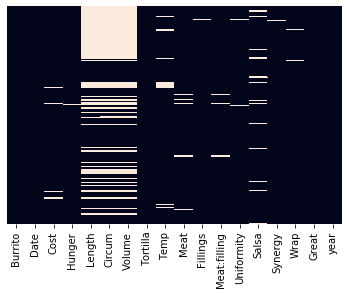

In [107]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)
plt.show()

In [106]:
## clean up the missing values in train now that the split is done
train.isnull().sum()

Burrito           0
Date              0
Cost              6
Hunger            1
Length          123
Circum          124
Volume          124
Tortilla          0
Temp             15
Meat             10
Fillings          1
Meat:filling      6
Uniformity        2
Salsa            20
Synergy           2
Wrap              2
Great             0
year              0
dtype: int64

In [0]:
train['Cost'] = train['Cost'].fillna((train['Cost'].mean()))
train['Hunger'] = train['Hunger'].fillna((train['Hunger'].mean()))
train['Length'] = train['Length'].fillna((train['Length'].mean()))
train['Circum'] = train['Circum'].fillna((train['Circum'].mean()))
train['Volume'] = train['Volume'].fillna((train['Volume'].mean()))
train['Temp'] = train['Temp'].fillna((train['Temp'].mean()))
train['Meat'] = train['Meat'].fillna((train['Meat'].mean()))
train['Fillings'] = train['Fillings'].fillna((train['Fillings'].mean()))
train['Meat:filling'] = train['Meat:filling'].fillna((train['Meat:filling'].mean()))
train['Uniformity'] = train['Uniformity'].fillna((train['Uniformity'].mean()))
train['Salsa'] = train['Salsa'].fillna((train['Salsa'].mean()))
train['Synergy'] = train['Synergy'].fillna((train['Synergy'].mean()))
train['Wrap'] = train['Wrap'].fillna((train['Wrap'].mean()))


In [111]:
## verify the work done above
train.isnull().sum()

Burrito         0
Date            0
Cost            0
Hunger          0
Length          0
Circum          0
Volume          0
Tortilla        0
Temp            0
Meat            0
Fillings        0
Meat:filling    0
Uniformity      0
Salsa           0
Synergy         0
Wrap            0
Great           0
year            0
dtype: int64

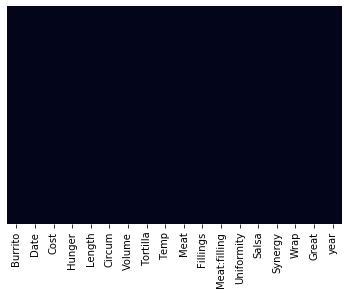

In [112]:
## visualize missing values
sns.heatmap(train.isnull(),yticklabels=False,cbar=False)
plt.show()

In [116]:
## now I need to encode ['Great'] with 0 for false and 1 for true
train.Great = train.Great.astype(int)
test.Great = test.Great.astype(int)
validate.Great = validate.Great.astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Baselines

In [115]:
train.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,year
0,California,2016-01-18,6.49,3.0,19.829886,22.042241,0.77092,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,2016
1,California,2016-01-24,5.45,3.5,19.829886,22.042241,0.77092,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,2016
2,Carnitas,2016-01-24,4.85,1.5,19.829886,22.042241,0.77092,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,2016
3,Asada,2016-01-24,5.25,2.0,19.829886,22.042241,0.77092,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,2016
4,California,2016-01-27,6.59,4.0,19.829886,22.042241,0.77092,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,2016


In [124]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

Baseline analysis.  This baseline score means that '0' or not great was the most common class of the two options.  The accuracy score is 59%

# Logistic Regression

In [138]:
train.head()

,Burrito,Date,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Great,year
0,California,2016-01-18,6.49,3.0,19.829886,22.042241,0.77092,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,2016
1,California,2016-01-24,5.45,3.5,19.829886,22.042241,0.77092,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,2016
2,Carnitas,2016-01-24,4.85,1.5,19.829886,22.042241,0.77092,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,2016
3,Asada,2016-01-24,5.25,2.0,19.829886,22.042241,0.77092,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,2016
4,California,2016-01-27,6.59,4.0,19.829886,22.042241,0.77092,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,1,2016


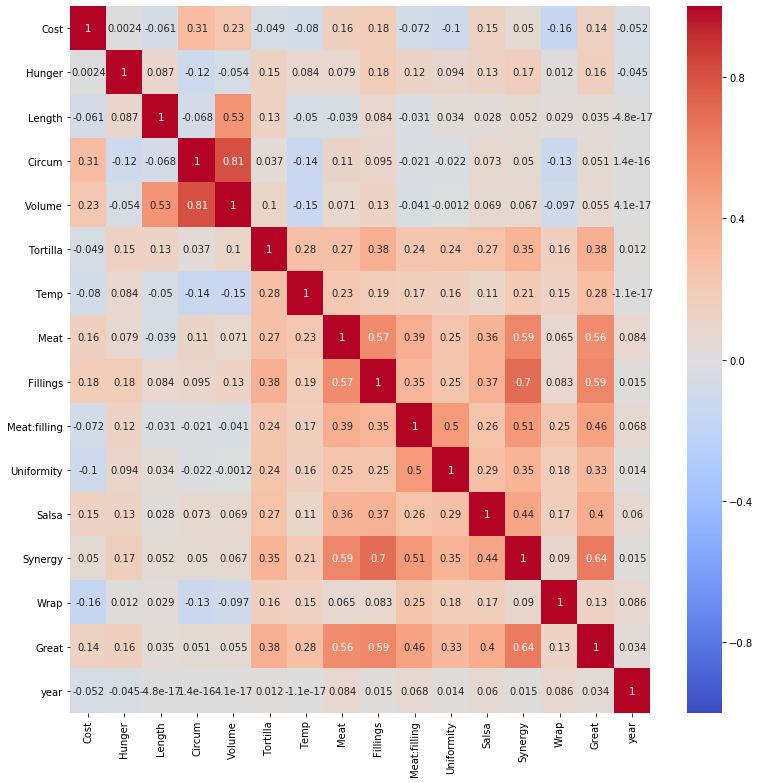

In [137]:
a = train.corr()
plt.figure(figsize=(13,13))
sns.heatmap(a, vmin=-1, cmap='coolwarm', annot=True)
plt.show()

In [0]:
## split into features matrix and target vector
y = train.iloc[:, 16]

## I am choosing to drop Synergy because it is highly correlated with meat and fillings
## dropped burrito for now since it is categorical and I don't want to encode it 
X = train.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [144]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [145]:
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0])

In [146]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[38,  5],
       [ 6, 26]])

In [147]:
## Accuracy and Precision
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.8533333333333334
Precision: 0.8387096774193549


In [0]:
X_validate_train = validate.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)
y_test_train = test.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)

# Validate

In [161]:
X_validate_train.shape, y_validate_test.shape

((85, 13), (85,))

In [0]:
y_val = validate.iloc[:, 16]
X_val = validate.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)

In [167]:
train.iloc[:, 16]

0      0
1      0
2      0
3      0
4      1
      ..
296    0
297    0
298    0
299    0
300    0
Name: Great, Length: 298, dtype: int64

In [0]:
X_train = train.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)
y_train = train.iloc[:, 16]
X_val = validate.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)
y_val = validate.iloc[:, 16]

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [170]:
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegressionCV(cv= 5,n_jobs = -1, random_state=0)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8470588235294118


# Test Accuracy

In [0]:
X_train = train.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)
y_train = train.iloc[:, 16]
X_test = test.drop(labels = ['Great', 'Synergy', 'Date', 'year', 'Burrito'], axis = 1)
y_test = test.iloc[:, 16]

In [173]:
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LogisticRegressionCV(cv= 5,n_jobs = -1, random_state=0)
model.fit(X_train_scaled, y_train)
print('Test Accuracy', model.score(X_test_scaled, y_test))

Test Accuracy 0.7894736842105263
